In [1]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt

# add ../mcjax to the path
import sys
sys.path.append('../../')

from mcjax.proba.gaussian import IsotropicGauss
from mcjax.mcmc.core import run_mcmc
from mcjax.mcmc.rwm import rwm_kernel



In [2]:
# initialize jax RNG
key = jr.key(0)

In [3]:
def run_rwm_experiment(key, dim, step_size, n_steps):
    # Define log-density
    mu = jnp.full((dim,), 1.0)
    log_var = jnp.log(2.0)
    dist = IsotropicGauss(mu=mu, log_var=log_var)
    logdensity = dist.logdensity

    # Initialize RWM kernel
    kernel = rwm_kernel(logdensity=logdensity, step_size=step_size, cov=jnp.eye(dim))
    x0 = jnp.zeros((dim,))
    state, params = kernel.init(x0)

    # Run sampler
    key, subkey = jr.split(key)
    output = run_mcmc(
        step=kernel.step,
        init_state=state,
        params=params,
        key=subkey,
        n_samples=n_steps,
        summarize=kernel.summarize
    )
    return output.summary.acceptance_rate

# Define dimensions and step size strategies
dim_arr = jnp.arange(1, 101, 10)
n_steps = 100_000

acc_rate_arr1 = []
acc_rate_arr2 = []
acc_rate_arr3 = []

for dim in dim_arr:
    print(f"Running RWM for dim = {dim}")
    key, subkey1, subkey2, subkey3 = jr.split(key, 4)
    acc_rate_arr1.append(run_rwm_experiment(subkey1, dim, 0.1 / jnp.sqrt(dim), n_steps))
    acc_rate_arr2.append(run_rwm_experiment(subkey2, dim, 0.1 / dim, n_steps))
    acc_rate_arr3.append(run_rwm_experiment(subkey3, dim, 0.1, n_steps))

Running RWM for dim = 1
Running RWM for dim = 11
Running RWM for dim = 21
Running RWM for dim = 31
Running RWM for dim = 41
Running RWM for dim = 51
Running RWM for dim = 61
Running RWM for dim = 71
Running RWM for dim = 81
Running RWM for dim = 91


Text(0.5, 1.0, 'Acceptance rate // step size')

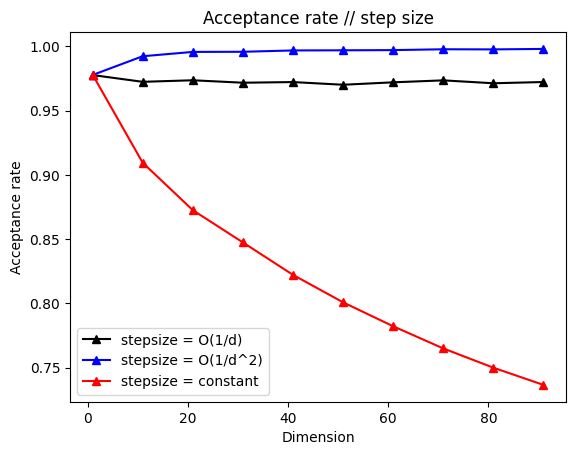

In [4]:
plt.plot(dim_arr,acc_rate_arr1, "k-^", label="stepsize = O(1/d)")
plt.plot(dim_arr,acc_rate_arr2, "b-^", label="stepsize = O(1/d^2)")
plt.plot(dim_arr,acc_rate_arr3, "r-^", label="stepsize = constant")
plt.legend()
plt.xlabel("Dimension")
plt.ylabel("Acceptance rate")
plt.title("Acceptance rate // step size")


In [5]:
dim_arr = jnp.arange(1, 101, 10)
ratio_arr = []
ell = 0.1
n_steps = 100_000

for dim in dim_arr:
    print(f"Running RWM for dim = {dim}")
    
    # Define target distribution
    mu = jnp.full((dim,), 1.0)
    log_var = jnp.log(2.0)
    dist = IsotropicGauss(mu=mu, log_var=log_var)
    logdensity = dist.logdensity

    # Define RWM kernel with step_size ~ ell / sqrt(d)
    step_size = ell / jnp.sqrt(dim)
    kernel = rwm_kernel(logdensity=logdensity, step_size=step_size, cov=jnp.eye(dim))

    # Initialize state
    x0 = jnp.zeros((dim,))
    state, params = kernel.init(x0)

    # Sample trajectory
    key, subkey = jr.split(key)
    output = run_mcmc(
        step=kernel.step,
        init_state=state,
        params=params,
        key=subkey,
        n_samples=n_steps,
        summarize=kernel.summarize
    )

    # Compute and store ratio: squared jump / acceptance rate
    summary = output.summary
    ratio_arr.append(summary.sq_jump / summary.acceptance_rate)


Running RWM for dim = 1
Running RWM for dim = 11
Running RWM for dim = 21
Running RWM for dim = 31
Running RWM for dim = 41
Running RWM for dim = 51
Running RWM for dim = 61
Running RWM for dim = 71
Running RWM for dim = 81
Running RWM for dim = 91


Text(0.5, 1.0, 'Ratio of Square jump distance / acceptance rate over dimension')

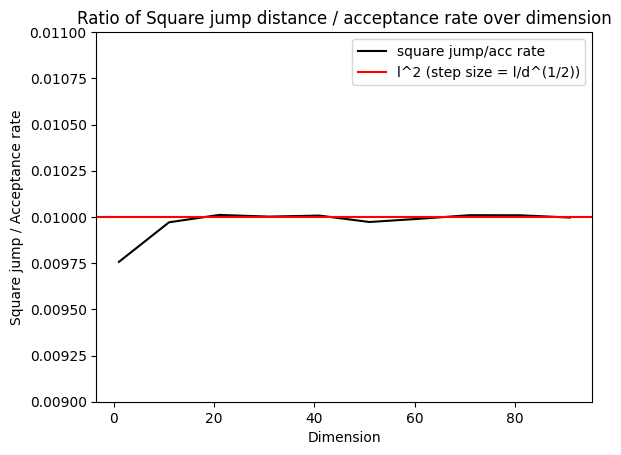

In [6]:
plt.plot(dim_arr,ratio_arr,label = "square jump/acc rate",color="black")
plt.axhline(y=ell**2,label="l^2 (step size = l/d^(1/2))",color = "red")
plt.xlabel("Dimension")
plt.ylabel("Square jump / Acceptance rate")
plt.legend()
eps_jitter = 1e-3
plt.ylim(ell**2 - eps_jitter, ell**2 + eps_jitter)
plt.title("Ratio of Square jump distance / acceptance rate over dimension")

In [7]:
# Efficiency and Acceptance rate
# Set a higher dimension (dim = 20)
dim = 20
# Target distribution
mu = jnp.full(dim,1.)
log_var = jnp.log(2)
dist = IsotropicGauss(mu=mu,log_var=log_var)
logdensity = dist.logdensity

In [16]:
def sample_RWM(key, x0, step_size, n_samples, dim):
    # Define the log-density
    mu = jnp.full((dim,), 0.0)
    log_var = jnp.log(1.0)
    dist = IsotropicGauss(mu=mu, log_var=log_var)
    logdensity = dist.logdensity

    # Create RWM kernel with sigma ~ step_size / sqrt(dim)
    kernel = rwm_kernel(logdensity=logdensity, step_size=step_size / jnp.sqrt(dim), cov=jnp.eye(dim))
    state, params = kernel.init(x0)

    output = run_mcmc(
        step=kernel.step,
        init_state=state,
        params=params,
        key=key,
        n_samples=n_samples,
        summarize=kernel.summarize
    )
    return output

# JIT single sampler
sample_RWM = jax.jit(sample_RWM, static_argnums=(3, 4))

# Batched over step_size (vmap over keys and step_size)
sample_RWM_batch = jax.vmap(sample_RWM, in_axes=(0, None, 0, None, None))
sample_RWM_batch = jax.jit(sample_RWM_batch, static_argnums=(3, 4))

# Run experiment
step_size_arr = np.linspace(0.01, 5.0, 100)
n_samples = 200_000
dim = 50  # example dimension

keys = jax.random.split(jax.random.PRNGKey(0), len(step_size_arr) + 1)
keys, key_ = keys[:-1], keys[-1]
x0 = jnp.zeros((dim,))

# Run batch of samplers across step sizes
mcmc_output_batch = sample_RWM_batch(keys, x0, step_size_arr, n_samples, dim)
traj_batch = mcmc_output_batch.traj
summary_batch = mcmc_output_batch.summary

Text(0.5, 1.0, 'Efficiency v.s. Acc rate')

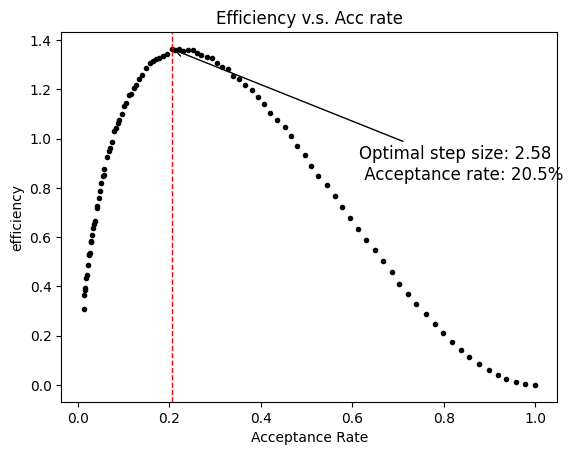

In [17]:
efficiency = [summary_batch.acceptance_rate[i]*step_size_arr[i]**2 for i in range(len(step_size_arr))]
plt.plot(summary_batch.acceptance_rate, efficiency, ".", color='black')
# find the optimal step size by maximizing the squared jump
index_opt = np.argmax(efficiency)
optimal_step_size = step_size_arr[index_opt]
optimal_acceptance_rate = summary_batch.acceptance_rate[index_opt]

# draw vertical line at the optimal step size
plt.axvline(optimal_acceptance_rate, color='red', lw=1, ls='--')
# add an arrow pointing to the optimal step size with the value
plt.annotate(f"Optimal step size: {optimal_step_size:.2f} \n Acceptance rate: {100*optimal_acceptance_rate:.1f}%",
                xy=(optimal_acceptance_rate, efficiency[index_opt]),
                xytext=(0.6, 0.6),
                textcoords='axes fraction',
                arrowprops=dict(facecolor='red', arrowstyle="->"),
                fontsize=12)
plt.xlabel("Acceptance Rate")
plt.ylabel("efficiency")
plt.title("Efficiency v.s. Acc rate")